# Library

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime

import os

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# model
import lightgbm as lgb

# shap
import shap

# my_tool
import sys
sys.path.append('../../')
import importlib
from utils import my_ds_tools as mdt
importlib.reload(mdt)

<module 'utils.my_ds_tools' from '../..\\utils\\my_ds_tools.py'>

# Load data

In [8]:
base_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
base_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# Config

In [9]:
y_col = 'SalePrice'
drop_cols = ['Id']

# Baseline

In [10]:
base_x_cols = drop_cols.copy()
base_x_cols.append(y_col)

In [11]:
base_x = base_df.drop(base_x_cols, axis=1)
base_y = base_df.loc[:, y_col]

In [12]:
numerical = []
categorical = []
for c, t in zip(base_x.columns, base_x.dtypes):
    if t == 'object':
        base_x[c] = base_x[c].astype(str)
        labels = base_x[c]
        if labels.isna().sum() == 0:
            labels.append(None)
        
        le = LabelEncoder()
        le.fit(labels)
        base_x[c] = le.transform(base_x[c])
        categorical.append(c)
    else:
        numerical.append(c)
base_x.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,2,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706,5,0,150,856,1,0,1,4,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,5,1,2003.0,1,2,548,4,4,2,0,61,0,0,0,0,3,4,4,0,2,2008,8,4
1,20,3,80.0,9600,1,2,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978,5,0,284,1262,1,0,1,4,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,4,1,1976.0,1,2,460,4,4,2,298,0,0,0,0,0,3,4,4,0,5,2007,8,4


In [13]:
print('categorical:')
print(categorical)
print('numerical:')
print(numerical)

categorical:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
numerical:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF'

In [14]:
base_x_train, base_x_test, base_y_train, base_y_test = train_test_split(base_x, base_y, train_size=0.7, random_state=1)

base_model = lgb.LGBMRegressor()
base_model.fit(base_x_train, base_y_train)

# テストデータを予測する
base_y_pred = base_model.predict(base_x_test)

# 精度を計算する
mae = metrics.mean_absolute_error(base_y_test, base_y_pred)
mae_mean = mae / base_y.mean()
print('MAE: %.2f' % mae)
print('MAE/MEAN: %.4f' % mae_mean)

rmse = np.sqrt(metrics.mean_squared_error(base_y_test, base_y_pred))
rmse_mean = rmse / base_y.mean()
print('RMSE: %.2f' % rmse)
print('RMSE/MEAN: %.4f' % rmse_mean)

MAE: 16380.41
MAE/MEAN: 0.0905
RMSE: 27653.13
RMSE/MEAN: 0.1528


# EDA

In [15]:
base_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [16]:
eda_df = base_df.copy()

In [17]:
eda_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [18]:
eda_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [19]:
eda_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

## SalePrice

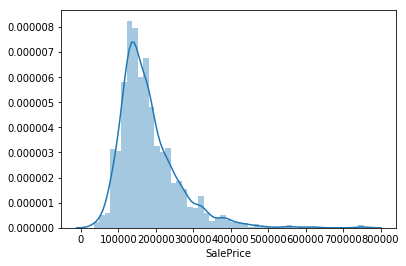

In [20]:
sns.distplot(eda_df[y_col])

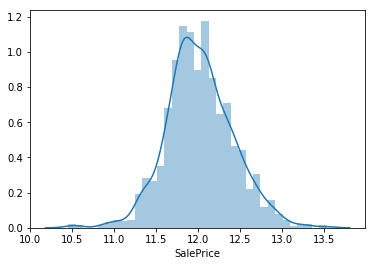

In [21]:
sns.distplot(eda_df[y_col].map(lambda x: np.log(x+1)))

## Categorical

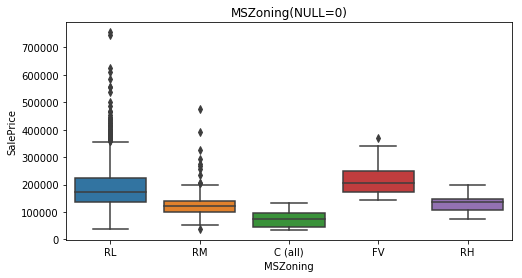

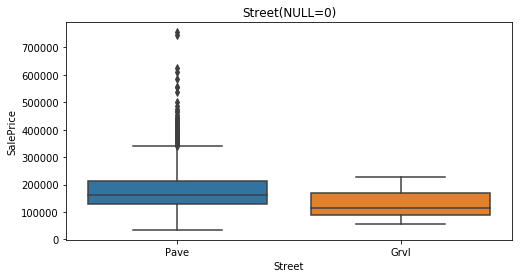

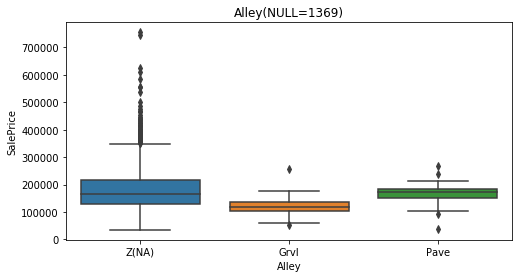

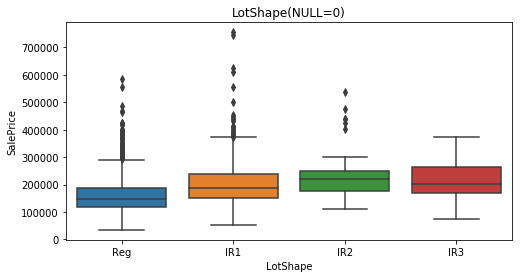

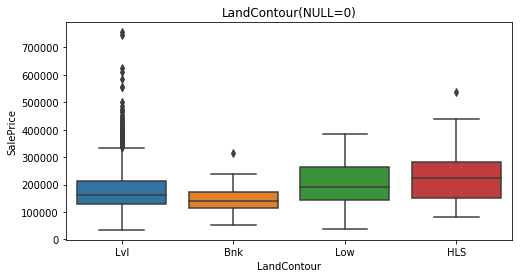

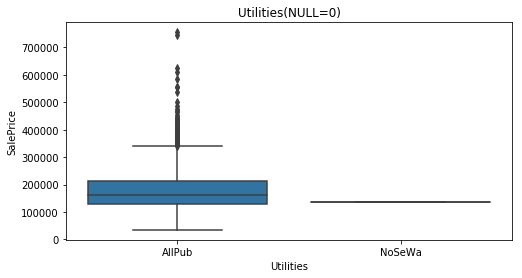

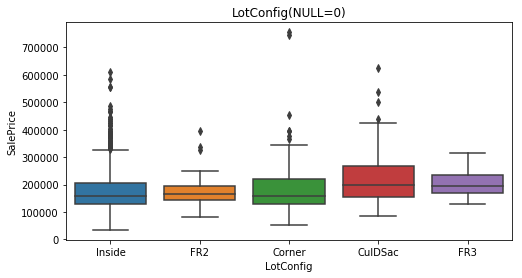

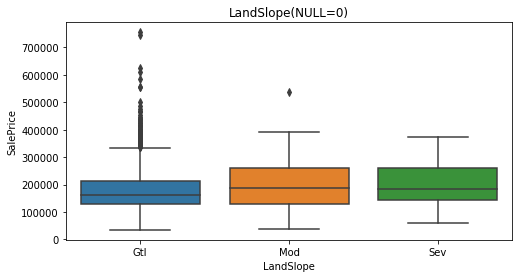

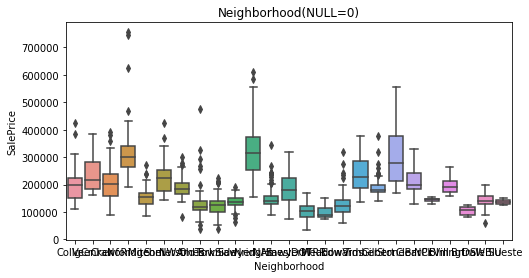

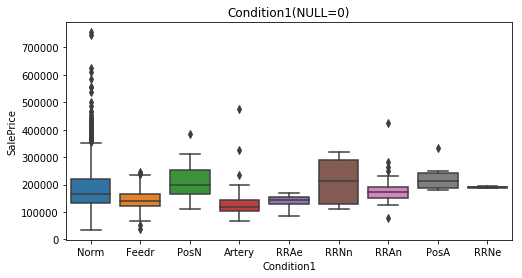

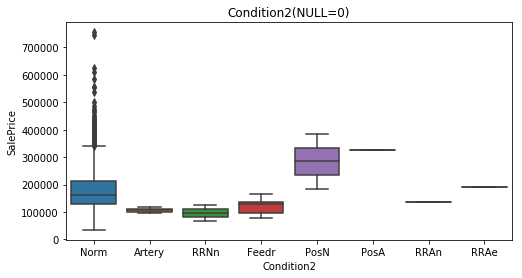

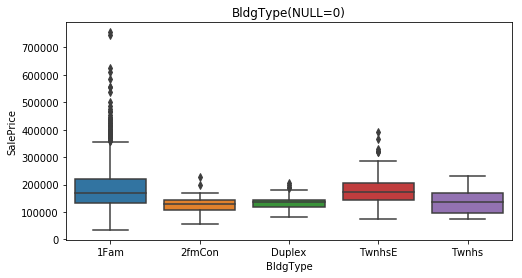

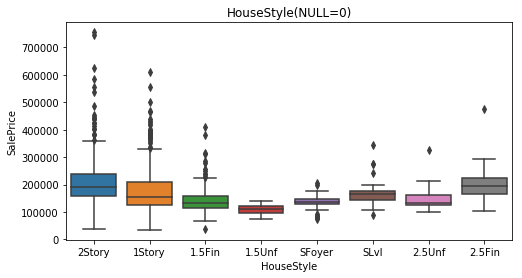

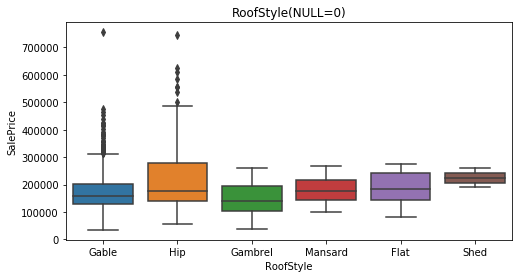

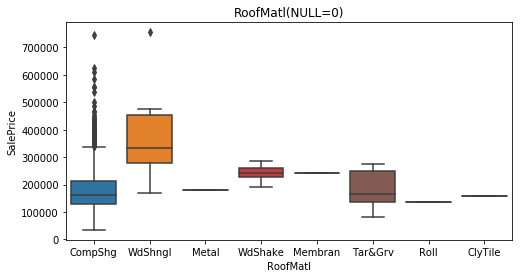

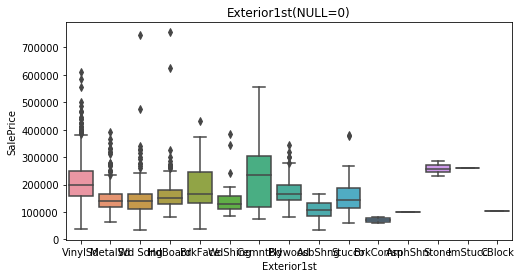

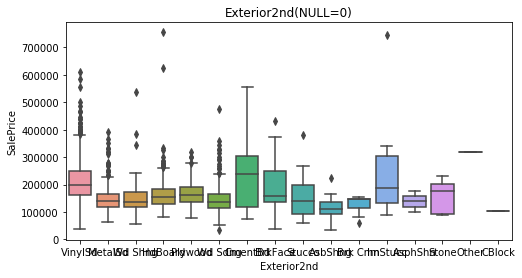

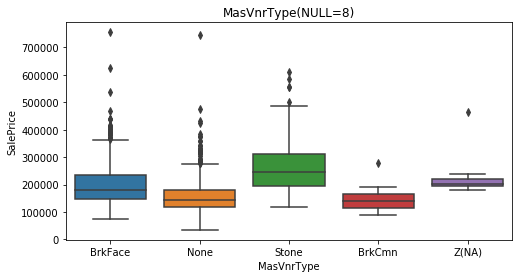

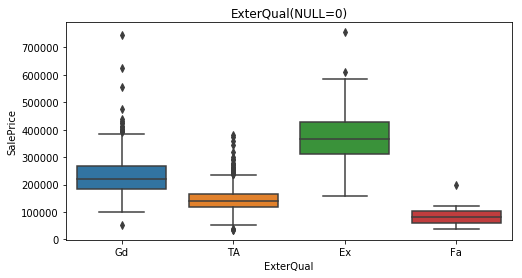

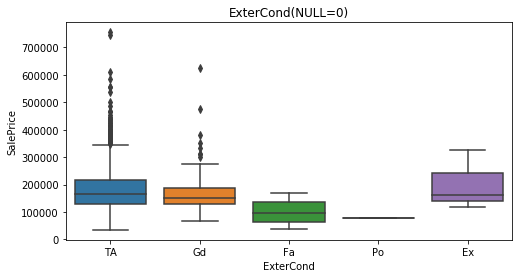

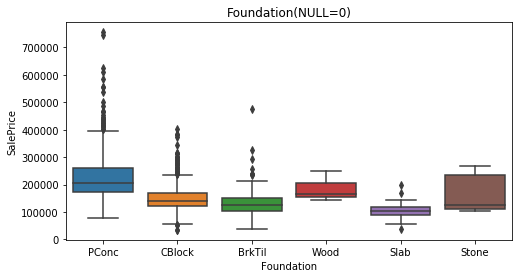

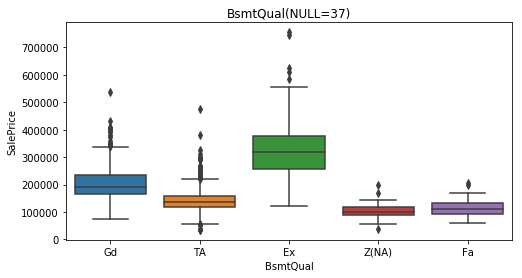

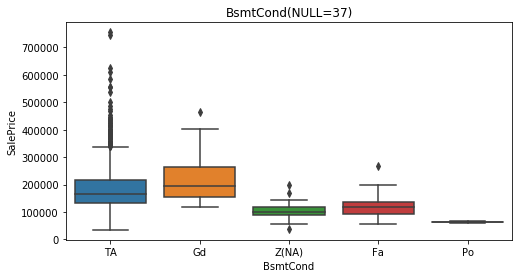

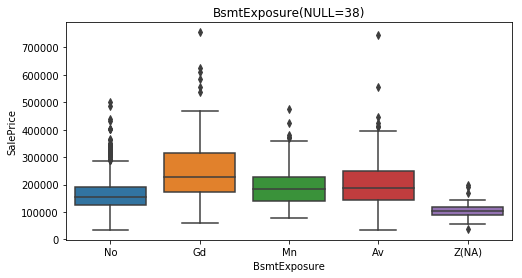

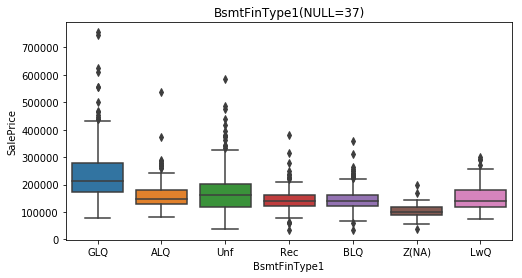

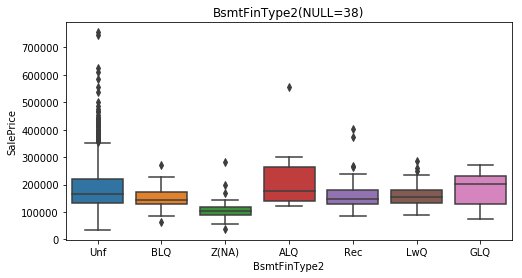

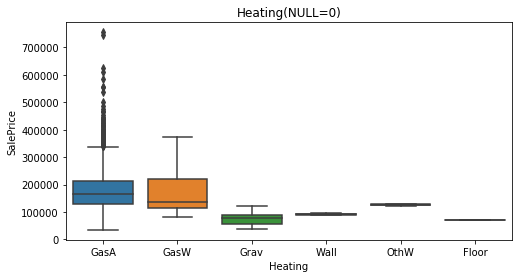

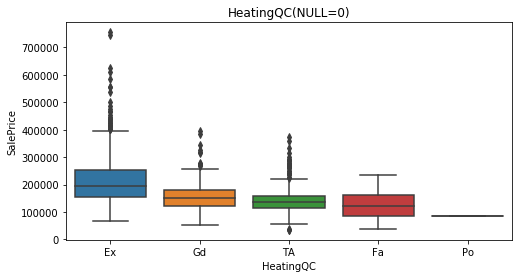

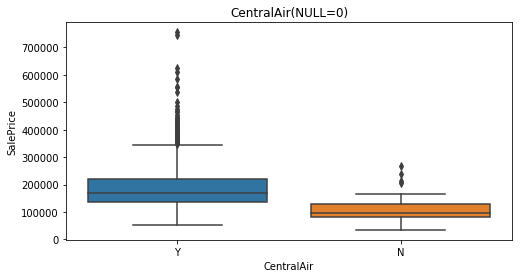

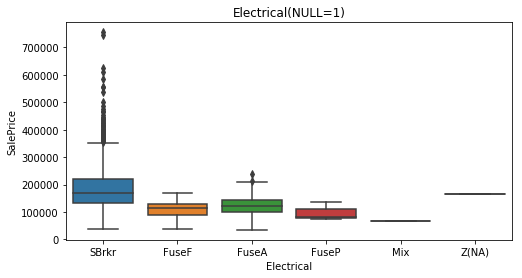

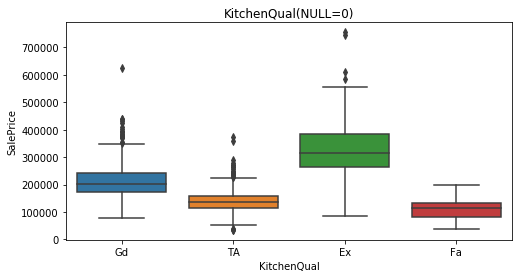

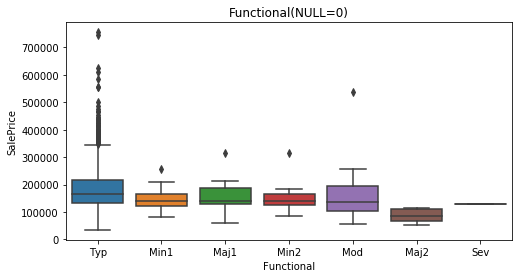

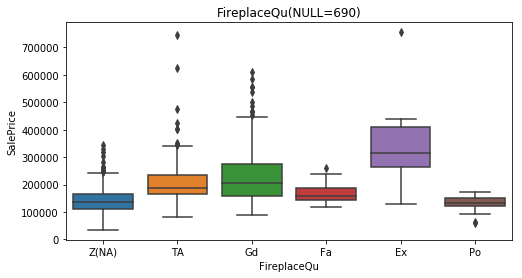

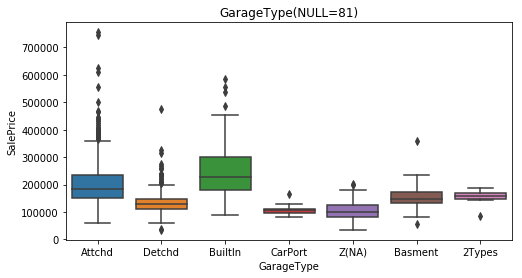

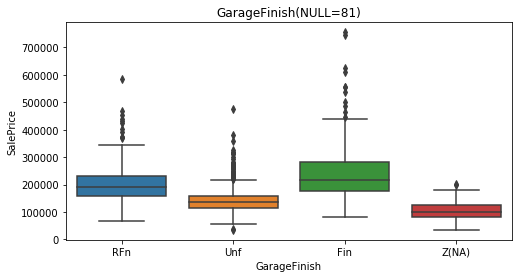

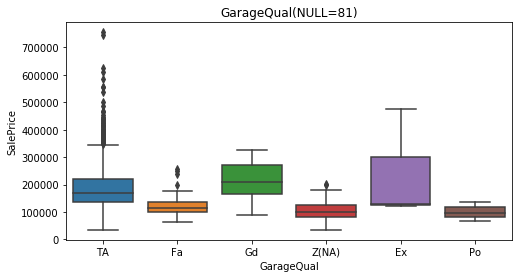

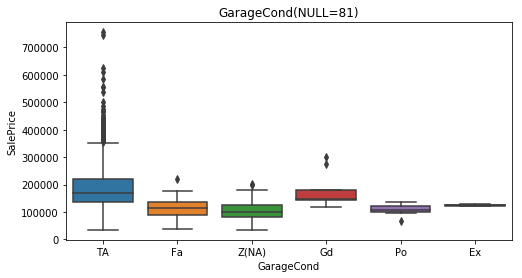

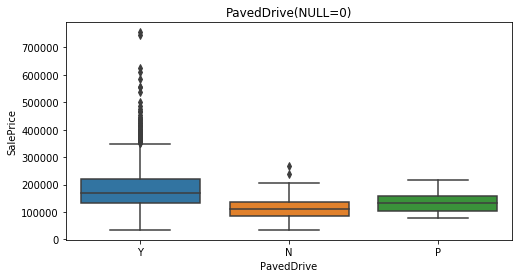

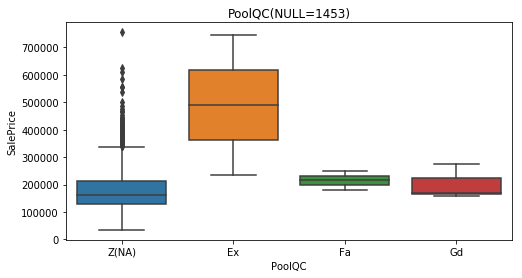

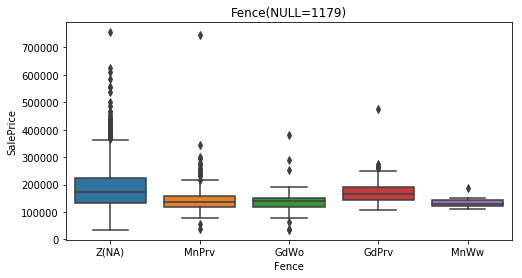

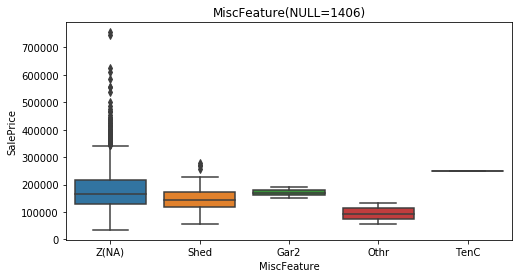

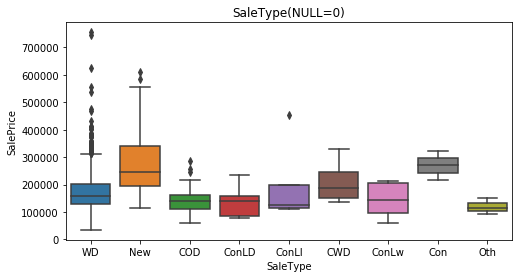

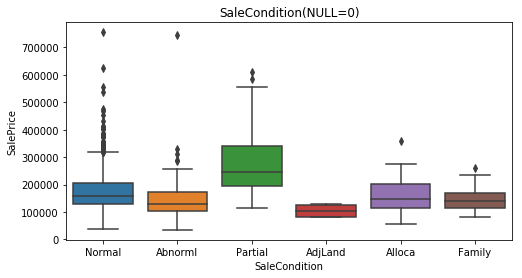

In [22]:
cate_cols = categorical.copy()
cate_cols.append(y_col)
cate_df = eda_df.loc[:, cate_cols]
cate_df = cate_df.fillna('Z(NA)')
for c in categorical:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=c, y=y_col, data=cate_df)
    plt.title(c + '(NULL=' + str(eda_df[c].isnull().sum()) + ')')

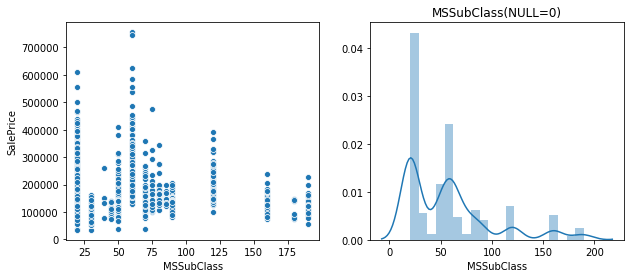

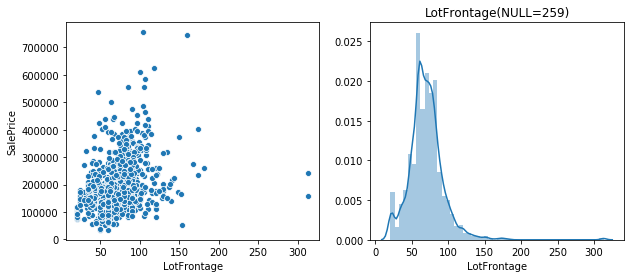

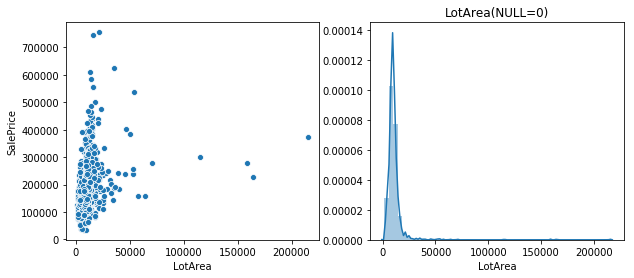

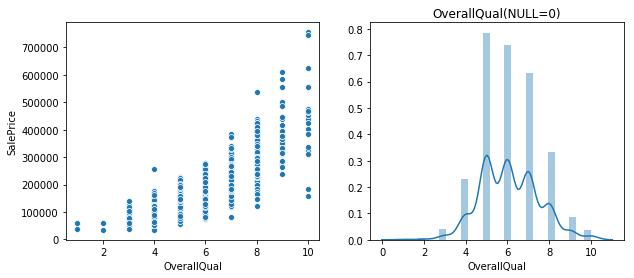

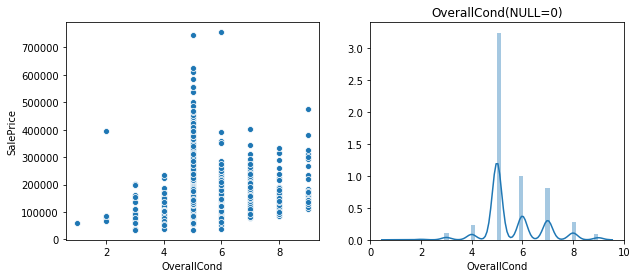

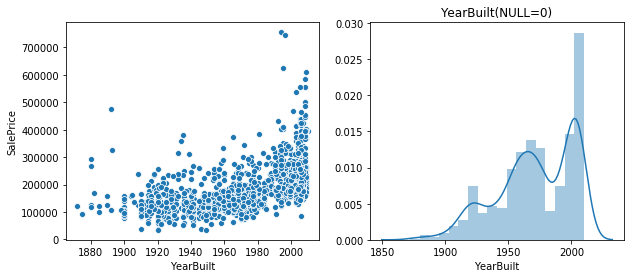

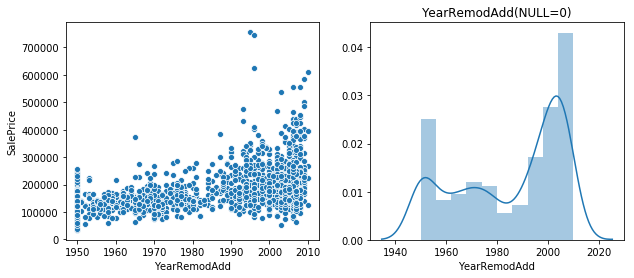

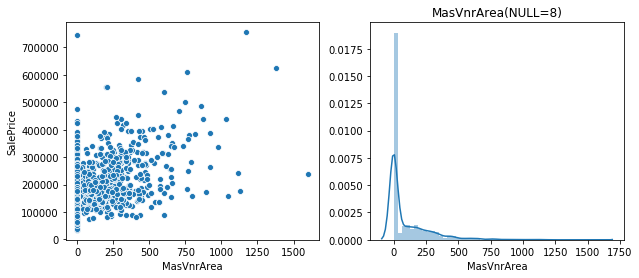

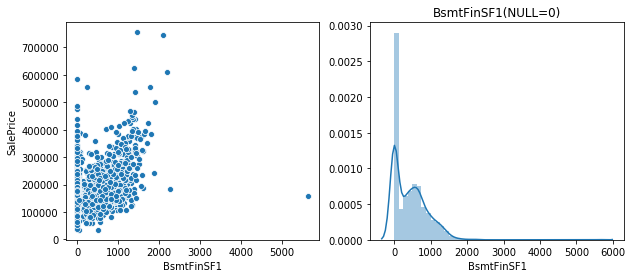

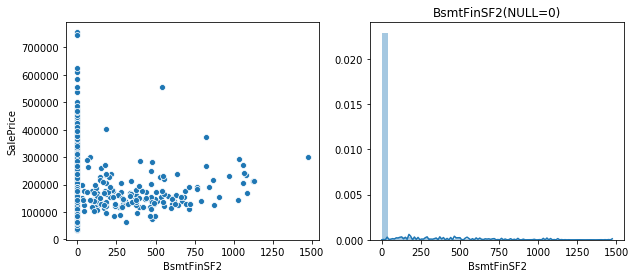

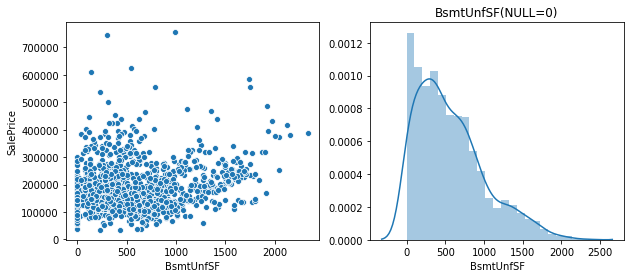

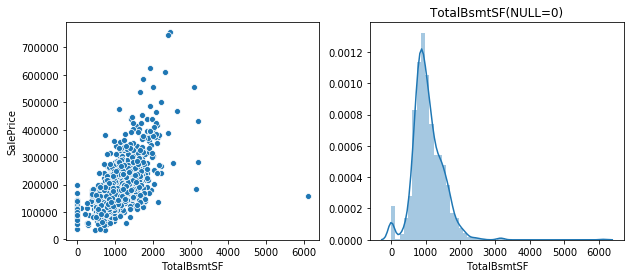

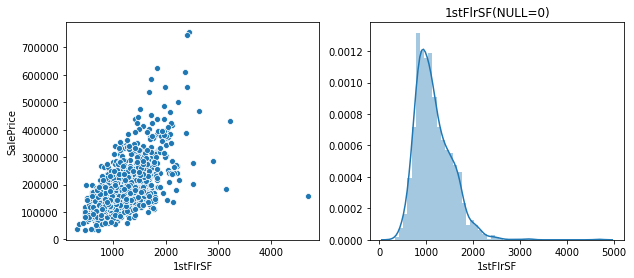

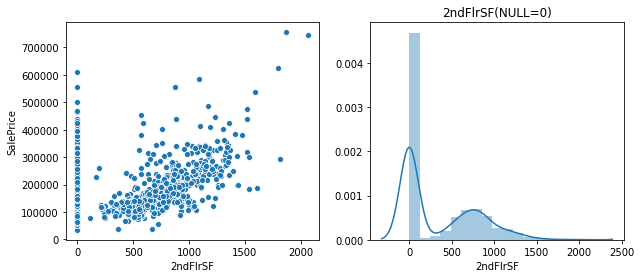

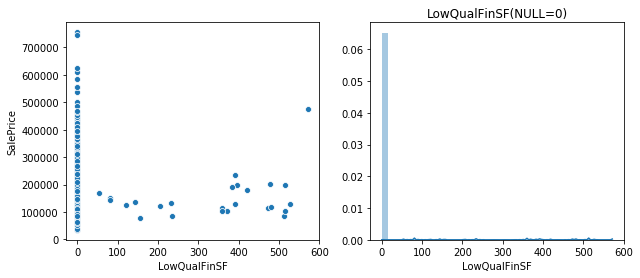

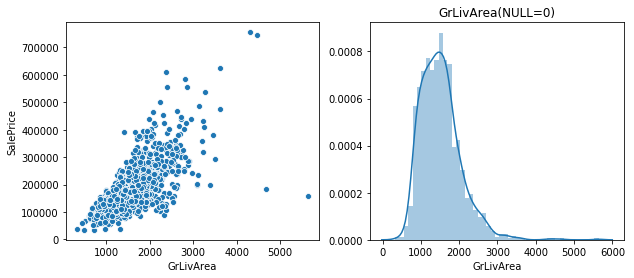

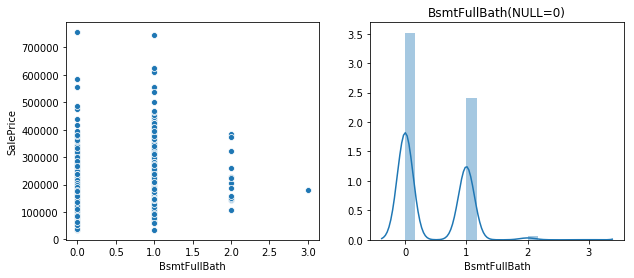

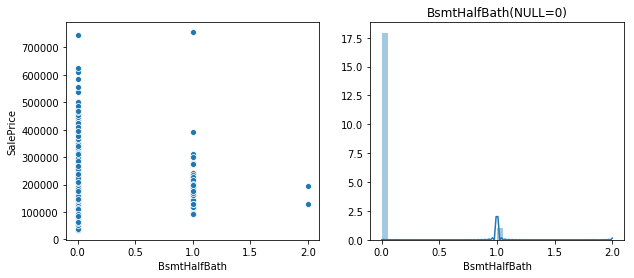

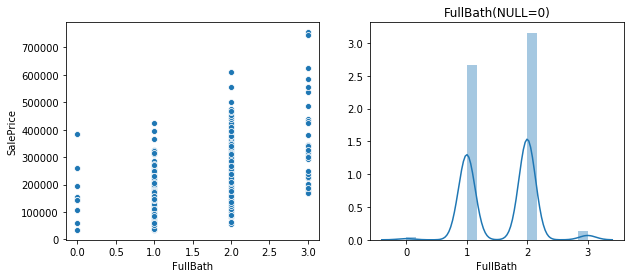

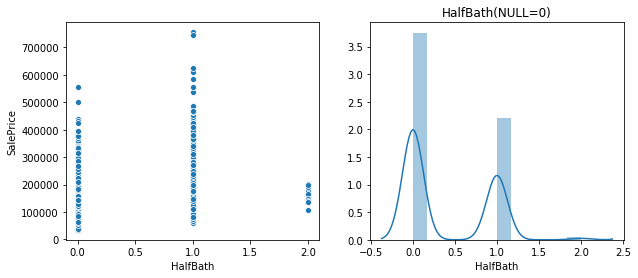

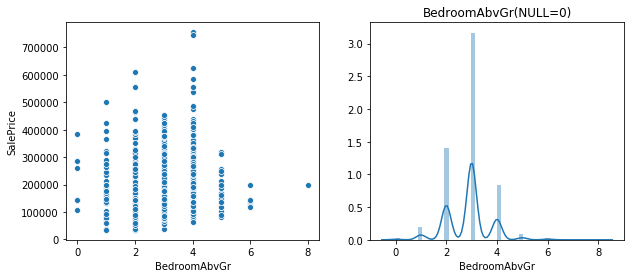

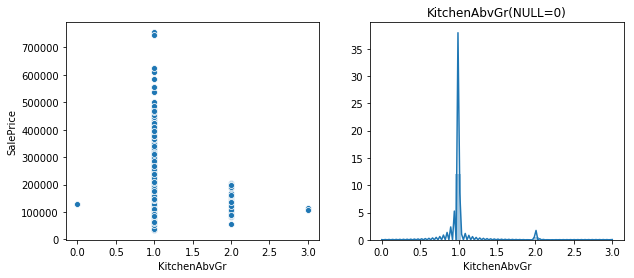

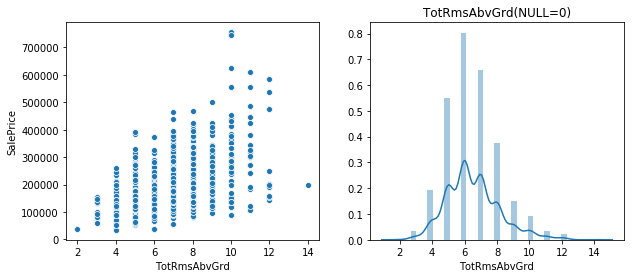

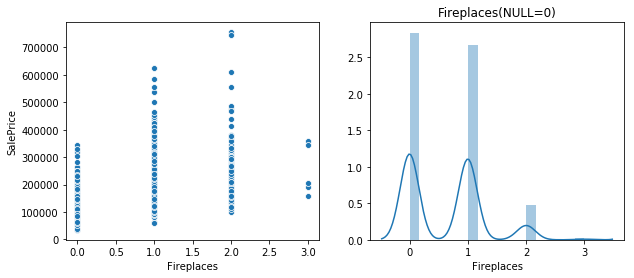

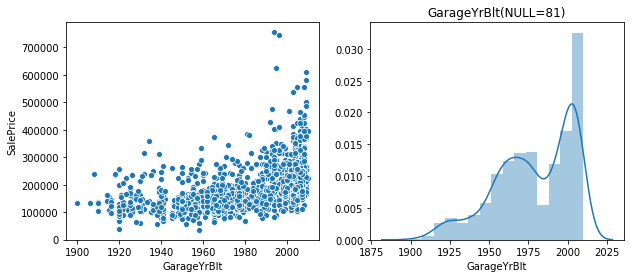

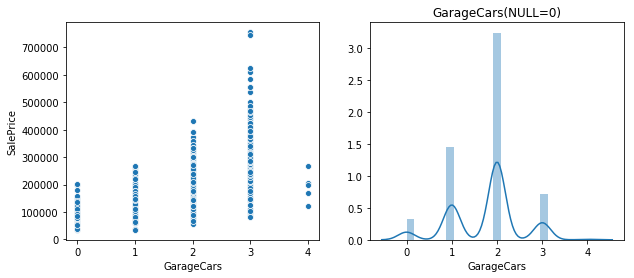

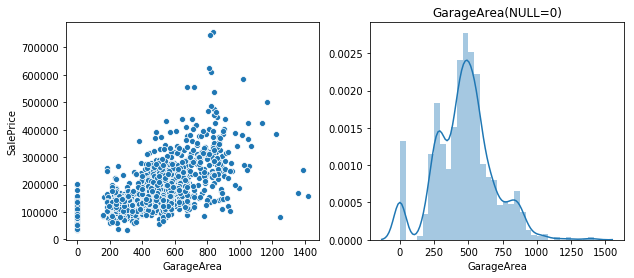

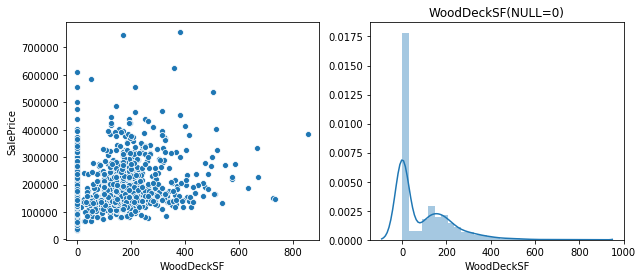

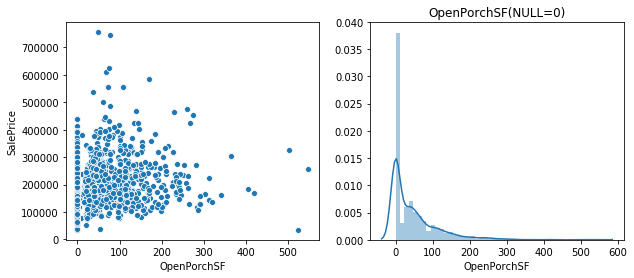

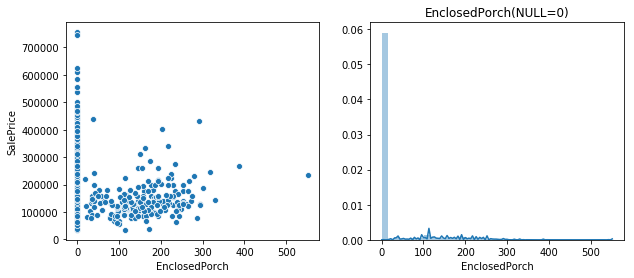

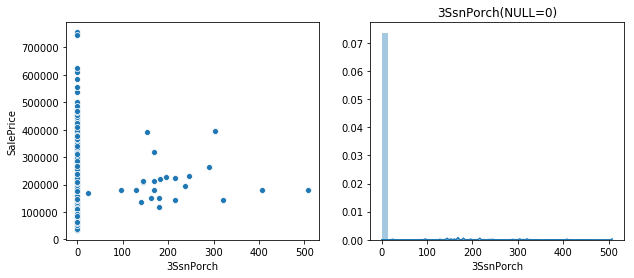

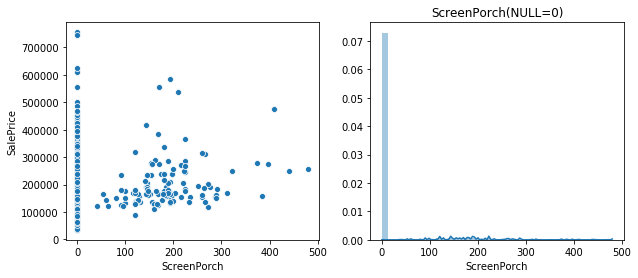

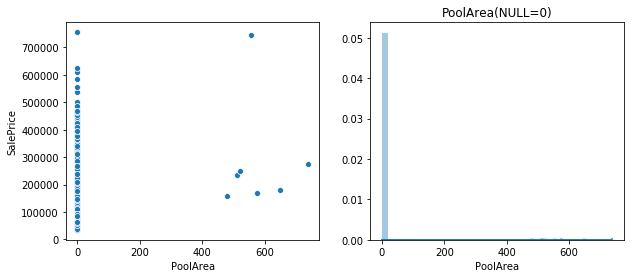

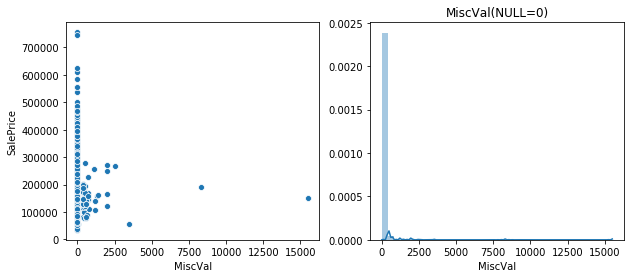

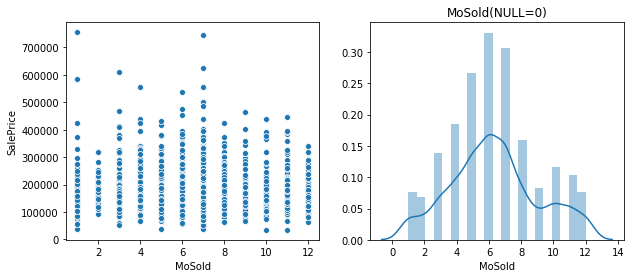

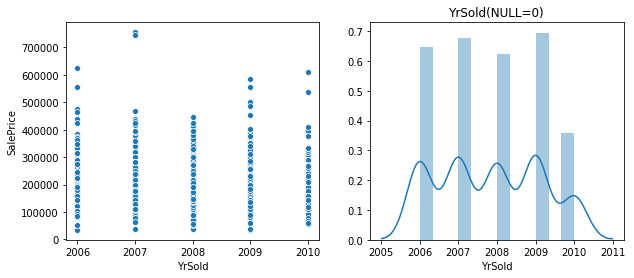

In [31]:
nume_cols = numerical.copy()
nume_cols.append(y_col)
nume_df = eda_df.loc[:, nume_cols]
# nume_df = nume_df.fillna(-10)
# nume_df = nume_df.query('TotalBsmtSF < 6000')
for c in numerical:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
#     plt.figure(figsize=(8, 4))
    hoge = nume_df[nume_df[c] >= 0]
    sns.scatterplot(x=c, y=y_col, data=hoge, ax=ax1)
    sns.distplot(hoge[c], ax=ax2)
    plt.title(c + '(NULL=' + str(nume_df[c].isnull().sum()) + ')')

In [24]:
nume_df.query('TotalBsmtSF > 5000')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice


## 相関係数

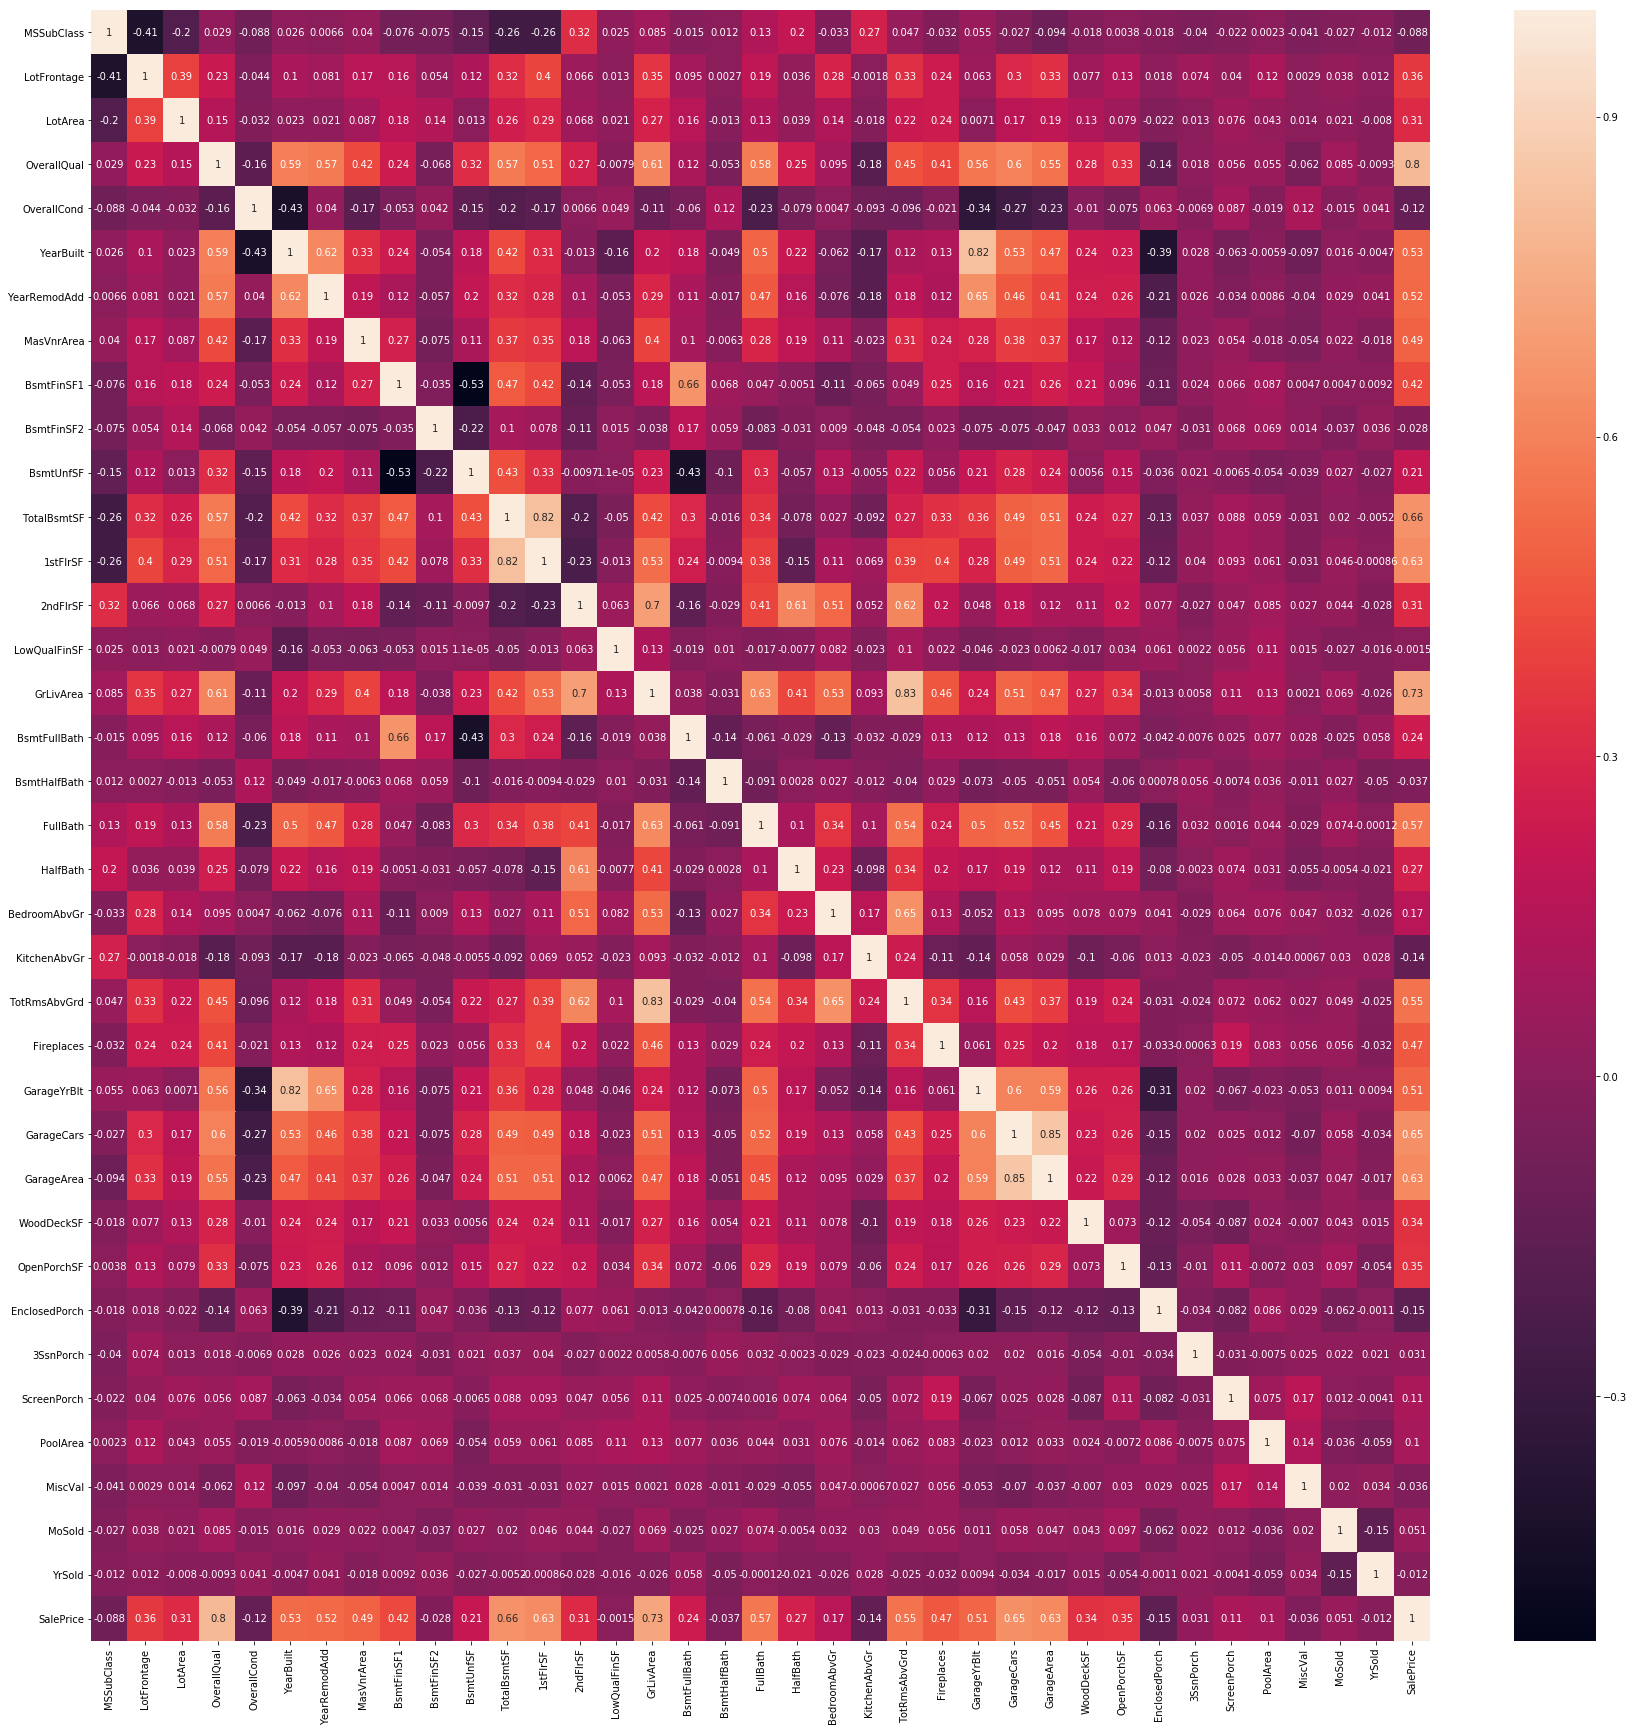

In [26]:
corr_df = nume_df.dropna()
correlation_matrix = np.corrcoef(corr_df.transpose())

# 相関行列のヒートマップを描く
plt.figure(figsize=(30,30))
sns.heatmap(correlation_matrix, annot=True,
            xticklabels=corr_df.columns,
            yticklabels=corr_df.columns)

In [27]:
type(correlation_matrix)

numpy.ndarray

In [28]:
fix_corr_df = pd.DataFrame(correlation_matrix, columns=corr_df.columns, index=corr_df.columns)
fix_corr_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.406291,-0.202641,0.029395,-0.087827,0.025720,0.006561,0.040178,-0.075600,-0.075419,-0.145565,-0.264226,-0.262942,0.319481,0.024713,0.085094,-0.015001,0.012330,0.131250,0.204009,-0.032986,0.266036,0.047174,-0.031638,0.054639,-0.027426,-0.093968,-0.018079,0.003764,-0.017762,-0.039730,-0.021767,0.002341,-0.040678,-0.027054,-0.012461,-0.088010
LotFrontage,-0.406291,1.000000,0.387107,0.227971,-0.043618,0.104240,0.080659,0.166100,0.157933,0.054305,0.123480,0.319286,0.402667,0.065919,0.012708,0.351667,0.095189,0.002678,0.187584,0.036295,0.281685,-0.001781,0.334939,0.238875,0.062535,0.298550,0.332580,0.076812,0.134722,0.018277,0.074099,0.040228,0.118667,0.002863,0.038358,0.012470,0.363607
LotArea,-0.202641,0.387107,1.000000,0.154881,-0.031877,0.022850,0.021000,0.086890,0.178195,0.142726,0.013232,0.255560,0.292440,0.067967,0.021105,0.273666,0.164697,-0.013136,0.127110,0.038646,0.138976,-0.018076,0.223320,0.239607,0.007100,0.174785,0.188710,0.130318,0.078659,-0.021959,0.013451,0.075659,0.042601,0.013900,0.021195,-0.007966,0.307868
OverallQual,0.029395,0.227971,0.154881,1.000000,-0.162436,0.588888,0.570362,0.418968,0.236438,-0.068045,0.324465,0.571650,0.513183,0.270998,-0.007876,0.607163,0.120163,-0.052880,0.577099,0.249664,0.094772,-0.178833,0.446472,0.410017,0.559828,0.595363,0.546369,0.281142,0.334626,-0.143963,0.017666,0.056170,0.054788,-0.061926,0.085202,-0.009309,0.801367
OverallCond,-0.087827,-0.043618,-0.031877,-0.162436,1.000000,-0.426226,0.039925,-0.166059,-0.052563,0.042188,-0.148787,-0.199177,-0.166280,0.006630,0.048674,-0.111678,-0.059753,0.122866,-0.229579,-0.078505,0.004726,-0.092754,-0.095811,-0.020647,-0.342912,-0.267809,-0.226457,-0.010373,-0.074980,0.062592,-0.006915,0.086913,-0.019251,0.119722,-0.015198,0.041080,-0.124556


In [29]:
multi_col_list = []
for c in fix_corr_df.columns:
    tmp = fix_corr_df[np.abs(fix_corr_df[c]) >= 0.7]
    if (len(tmp.index) == 1) or (c == y_col):
        continue
    
    print('feature: ' + c)
    for i in tmp.index:
        if (i != c) and (i != y_col):
            print(i)
            multi_col_list.append(sorted([c, i]))
    print('-------------------------------')

feature: OverallQual
-------------------------------
feature: YearBuilt
GarageYrBlt
-------------------------------
feature: TotalBsmtSF
1stFlrSF
-------------------------------
feature: 1stFlrSF
TotalBsmtSF
-------------------------------
feature: GrLivArea
TotRmsAbvGrd
-------------------------------
feature: TotRmsAbvGrd
GrLivArea
-------------------------------
feature: GarageYrBlt
YearBuilt
-------------------------------
feature: GarageCars
GarageArea
-------------------------------
feature: GarageArea
GarageCars
-------------------------------


In [30]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]
get_unique_list(list(multi_col_list))
# set(multi_col_list)

[['GarageYrBlt', 'YearBuilt'],
 ['1stFlrSF', 'TotalBsmtSF'],
 ['GrLivArea', 'TotRmsAbvGrd'],
 ['GarageArea', 'GarageCars']]